<a href="https://colab.research.google.com/github/caffein1371/Carrier-Owl/blob/master/interview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mid career assignment(CV+Classification)**

**1-1 実装**

# EDA

In [20]:
#ライブラリ
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/MyDrive/interview/ABEJA/dataset_interview.csv')
print(df)

                 0           1           2           3           4  label
0       122.254980 -316.232650  -51.128054 -556.887773  -49.236176      5
1       -58.995946  393.699146 -161.999853  529.245672 -313.172495      4
2      -796.965065 -607.421427  295.521428  109.111587   25.661300      1
3       185.968028  223.865456  595.139067   17.734789  339.045266      2
4      -730.487099 -162.005114 -237.058238   85.692674 -149.535557      1
...            ...         ...         ...         ...         ...    ...
48092  -954.913620 -737.551437  315.819535  165.828342 -122.813472      1
48093   305.693698 -549.646460  -22.321575  277.929574  848.717256      2
48094  -271.507038  590.077819  341.365142 -435.008248  673.659307      4
48095  -310.224940 -116.728300  635.728681 -282.528062 -155.236960      5
48096  1058.862304  -83.393057  731.337374  791.045793  177.700694      6

[48097 rows x 6 columns]


**EDA**

データの大きさ(48097 rows x 6 columns)
とデータの形式（ラベルと5つの特徴量とIDで構成）ということは理解したので、pandasの関数を使い、データの情報を得る

In [4]:
#欠損値の確認　データのtypeの確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48097 entries, 0 to 48096
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       48097 non-null  float64
 1   1       48097 non-null  float64
 2   2       48097 non-null  float64
 3   3       48097 non-null  float64
 4   4       48097 non-null  float64
 5   label   48097 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 2.2 MB


欠損値はなし　ラベル以外はfloat型

In [6]:
#データの統計量を出力
df.describe()

0             1             2             3             4  \
count  48097.000000  48097.000000  48097.000000  48097.000000  48097.000000   
mean     -74.012773    -49.163586     66.113457     79.751523     42.148486   
std      544.931452    460.369733    429.074760    437.723799    394.669667   
min    -1081.144794  -1428.858379  -1361.445386  -1525.175643  -1297.710607   
25%     -458.784954   -375.316510   -209.560841   -208.759536   -243.155355   
50%      -83.254371   -125.037157     81.086057    100.669006     38.109662   
75%      278.738695    256.862083    361.009433    352.765136    310.843765   
max     2362.403606   1357.262954   1476.090518   1584.536666   1388.643195   

              label  
count  48097.000000  
mean       4.265464  
std        2.497215  
min        0.000000  
25%        2.000000  
50%        4.000000  
75%        6.000000  
max        8.000000

他の特徴量と比べて特徴量0だけ標準偏差が少し大きく、散らばっている．ハズレ値の処理が必要かもしれないと考察する

In [12]:
#正解ラベルに偏りが無いかを確かめる
df["label"].value_counts()

label
1    7877
2    6990
6    6876
8    6825
4    6824
5    6313
7    3646
0    1726
3    1020
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='Count'>

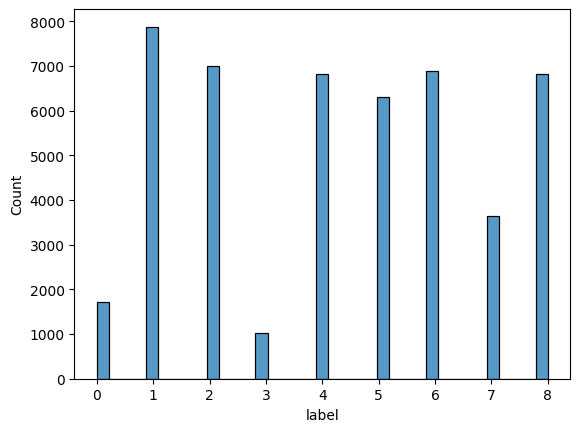

In [13]:
sns.histplot(df["label"])

この問題は0-8からラベルが振られた9クラスの分類問題だということがわかった．またラベル０、ラベル３が極端に少ないことが見てわかる．モデルをつくる上でこの偏りが一つの課題となることがわかった


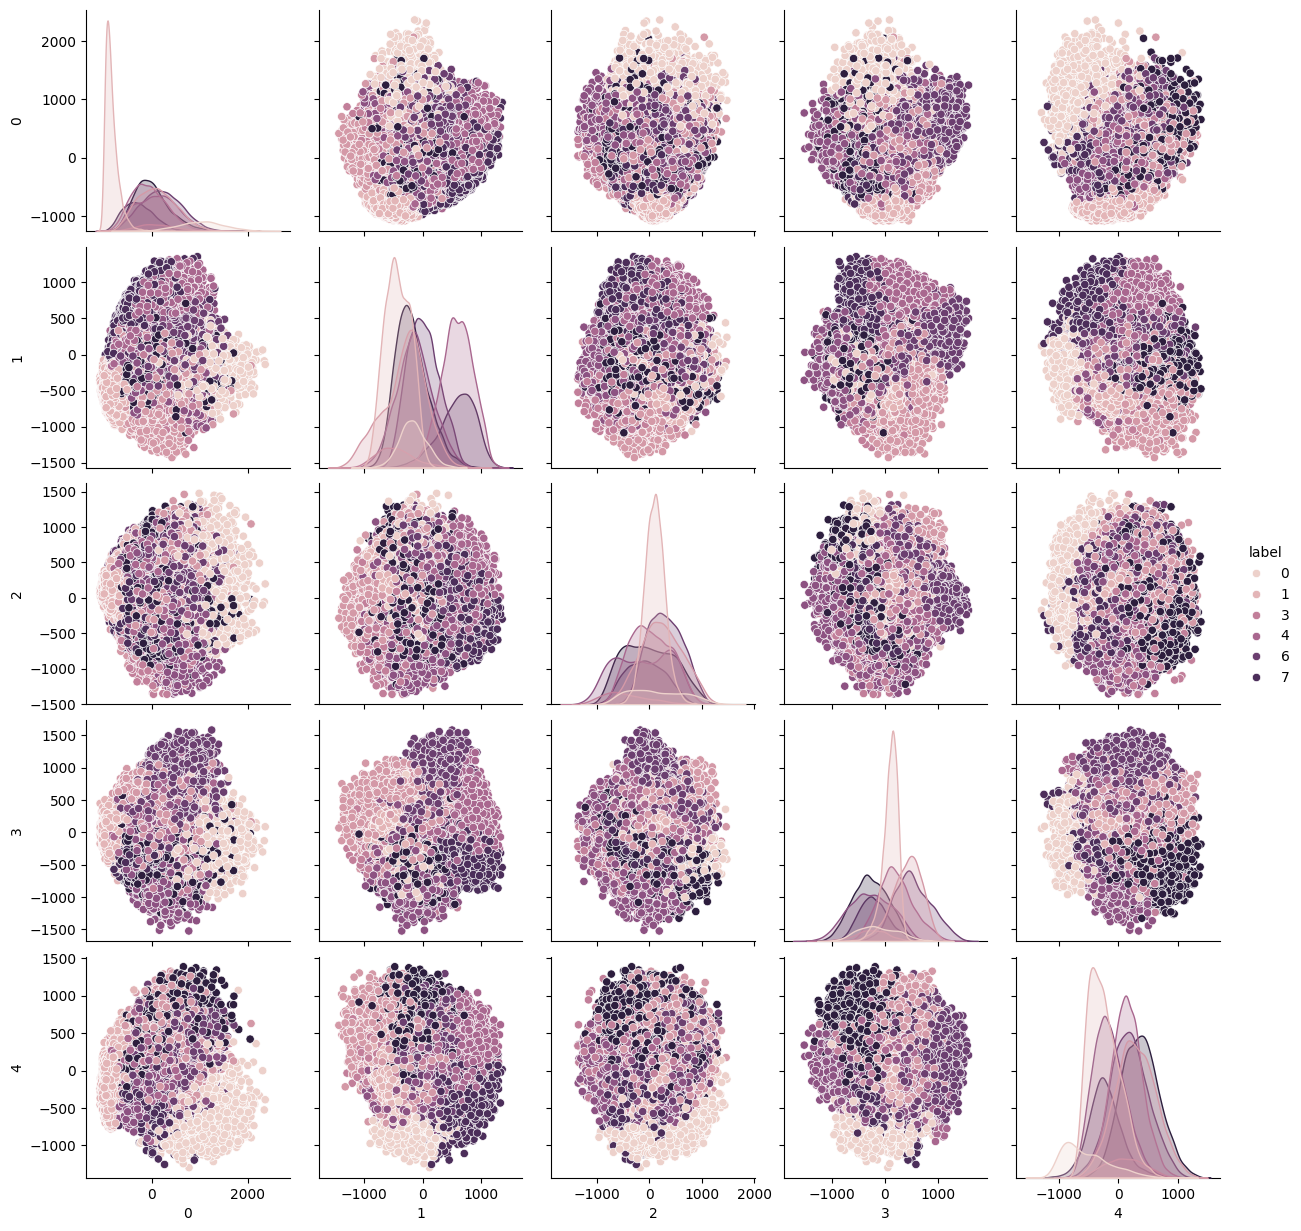

In [14]:
#特徴量ごとの散布図を作成．ラベルによって色を変える
sns.pairplot(df, hue="label")

それぞれのラベルに対して特徴量が幅広く散布しており、単純なモデル（ex:線形モデル）で分離することは難しいと考察する

<Axes: >

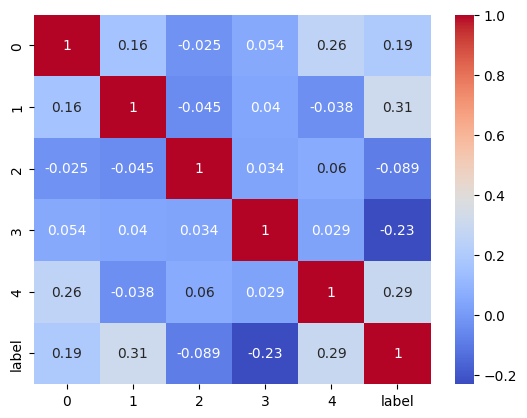

In [15]:
#相関係数
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

それぞれの特徴量とラベルの相関係数の絶対値は低く（一番高い相関係数でも0.31→非常に弱い相関である）、先ほどの散布図でも記述したが、単純な線形分布でモデルを表現するのは困難であると考える（ex単回帰モデル）

<Axes: >

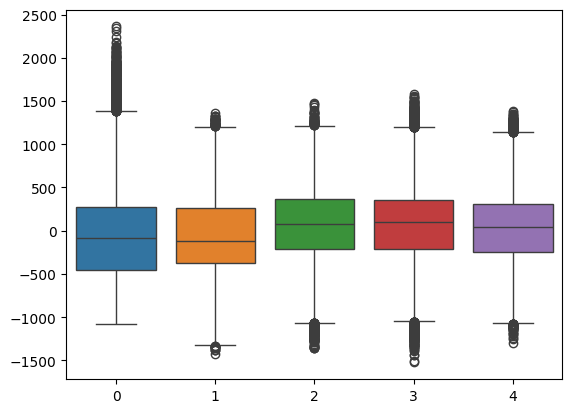

In [16]:
#箱ひげ図をプロット
sns.boxplot(data=df.iloc[:, :-1])

箱ひげ図を見ると、ハズレ値があることがわかる．実際に四分位範囲を計算し、ハズレ値をDataframeから取り除く処理を行う

In [18]:
# Q1（25%の値）とQ3（75%の値）を計算
Q1 = df.iloc[:, :-1].quantile(0.25)  # 特徴量のみ
Q3 = df.iloc[:, :-1].quantile(0.75)
IQR = Q3-Q1  # IQR(四分位範囲)を計算

# 外れ値の閾値
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5*IQR

In [19]:
# 条件に合う行を削除
df_cleaned = df[~((df.iloc[:, :-1] < lower_bound) | (df.iloc[:, :-1] > upper_bound)).any(axis=1)]

# 結果の確認
print(f"元のデータ数: {len(df)}")
print(f"外れ値除去後のデータ数: {len(df_cleaned)}")

元のデータ数: 48097
外れ値除去後のデータ数: 46770


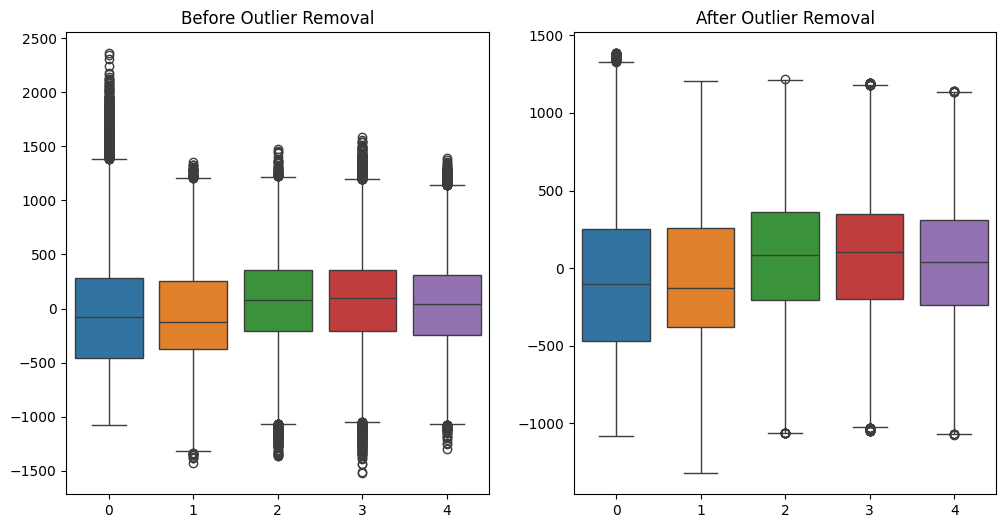

In [21]:
plt.figure(figsize=(12, 6))

# 除去前
plt.subplot(1, 2, 1)
sns.boxplot(data=df.iloc[:, :-1])
plt.title("Before Outlier Removal")

# 除去後
plt.subplot(1, 2, 2)
sns.boxplot(data=df_cleaned.iloc[:, :-1])
plt.title("After Outlier Removal")

plt.show()

約2000のデータがハズレ値として除去された．除去されたデータについてもう一度見ていく．
以下、外れ値を削除した後も同様の分析を行い、元のデータに大きな影響が与えていないかを確認する

<Axes: xlabel='label', ylabel='Count'>

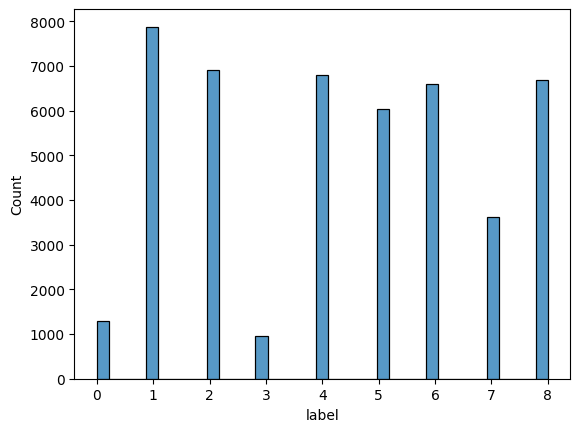

In [24]:
sns.histplot(df_cleaned["label"])

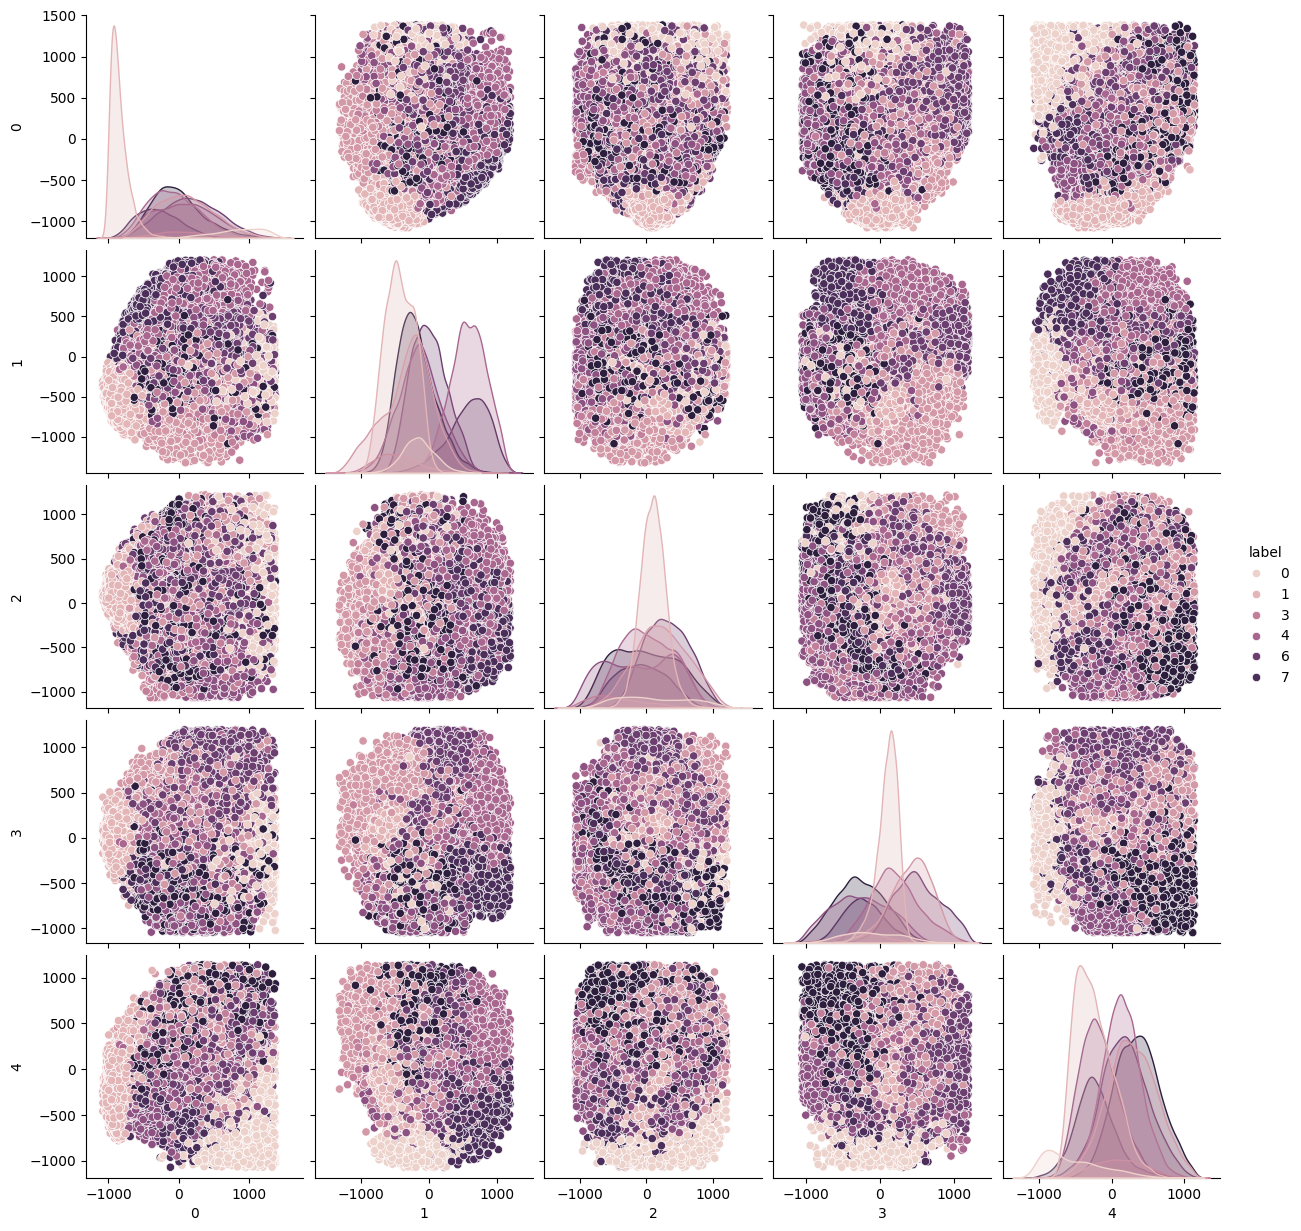

In [25]:
#特徴量ごとの散布図を作成．ラベルによって色を変える
sns.pairplot(df_cleaned, hue="label")

<Axes: >

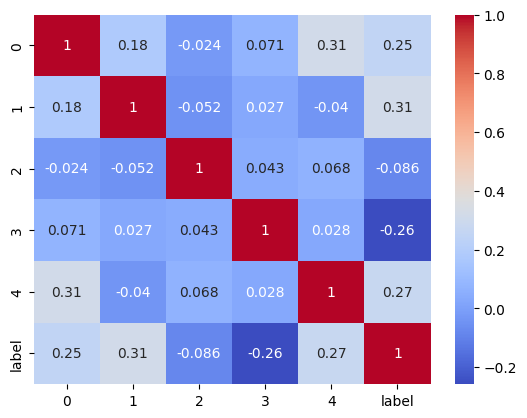

In [23]:
#相関係数
sns.heatmap(df_cleaned.corr(), annot=True, cmap="coolwarm")

上記のデータを用いてモデル作成を行う．それぞれの特徴量の差が小さいので難しいタスクであると考察する

# モデル作成&評価

方針：今回のタスクは7分類モデルとなっている．まずはニューラルネットワークの作成を行う．
作成するニューラルネットワークは（入力層→隠れ層→出力層）の単純なもので行う．正解ラベルのデータセットの量を補うためにSMOTEを用いてオーバーサンプリングを行い、不均衡を無くす方針でいく

In [44]:
#ライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

**評価指標について**
今回の9分類タスクでは、データ数の不均衡を配慮して、Accuracyに加えてF1スコア,AUCを用いて評価を行う

In [51]:
def evaluate_model(model, X_val, y_val):
    model.eval()  # 評価モードに切り替え
    with torch.no_grad():
        # 入力データをモデルに通す
        y_pred = model(X_val)

        # 最大確率のクラスを予測として取得
        y_pred_class = torch.argmax(y_pred, dim=1)

        # F1スコア（マクロ平均）
        f1 = f1_score(y_val, y_pred_class, average='macro')

        # AUC (One-vs-Rest方式)
        y_val_onehot = nn.functional.one_hot(y_val, num_classes=y_pred.size(1))  # One-hot encoding
        auc = roc_auc_score(y_val_onehot, torch.softmax(y_pred, dim=1), multi_class='ovr', average='macro')

        # 精度（Accuracy）
        accuracy = accuracy_score(y_val, y_pred_class)

    return accuracy, f1, auc

以下が学習タスクの実装である

In [52]:
# 特徴量とラベル
X = df_cleaned.iloc[:, :-1].values  # 特徴量
y = df_cleaned.iloc[:, -1].values   # ラベル

箱ひげ図より全ての特徴量が同じスケールの範囲内で分布しているわけでは無いため、データを平均0,標準偏差1の値で標準化する．


In [53]:
# データの標準化
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [54]:
# 訓練データとテストデータに分割 (80%: 訓練, 20%: テスト)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [55]:
# クラス不均衡への対応を行う
print("Before SMOTE:", Counter(y_train))  # SMOTE適用前のクラス分布

# SMOTEで少数クラスを増やす
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_resampled))  # SMOTE適用後のクラス分布

Before SMOTE: Counter({1: 6302, 2: 5533, 4: 5430, 8: 5353, 6: 5270, 5: 4829, 7: 2891, 0: 1039, 3: 769})
After SMOTE: Counter({7: 6302, 5: 6302, 1: 6302, 6: 6302, 0: 6302, 4: 6302, 2: 6302, 8: 6302, 3: 6302})


In [61]:
# PyTorchのTensorに変換
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [62]:
# ニューラルネットワークの定義
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # ソフトマックスは損失関数で処理する

In [63]:
# モデル作成
input_size = X.shape[1]  # 特徴量の数
hidden_size = 32  # 隠れ層のユニット数
output_size = len(np.unique(y))  # 7クラス分類

model = SimpleNN(input_size, hidden_size, output_size)

# 損失関数と最適化手法
criterion = nn.CrossEntropyLoss()  # ソフトマックス + NLLLoss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 学習ループ
num_epochs = 100
batch_size = 32

In [ ]:
for epoch in range(num_epochs):
    # 順伝播
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # 逆伝播と最適化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        # バリデーションデータで評価
        accuracy, f1, auc = evaluate_model(model, X_test_tensor, y_test_tensor)

        # 結果を表示
        print(f"Epoch {epoch+1}/{num_epochs} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")

In [64]:
# モデル評価
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, dim=1)
    accuracy = (y_pred_classes == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")

Epoch 10/100 - Accuracy: 0.5414, F1 Score: 0.4899, AUC: 0.9177
Epoch 20/100 - Accuracy: 0.6033, F1 Score: 0.5546, AUC: 0.9403
Epoch 30/100 - Accuracy: 0.6593, F1 Score: 0.6166, AUC: 0.9505
Epoch 40/100 - Accuracy: 0.6923, F1 Score: 0.6523, AUC: 0.9557
Epoch 50/100 - Accuracy: 0.7146, F1 Score: 0.6768, AUC: 0.9593
Epoch 60/100 - Accuracy: 0.7280, F1 Score: 0.6899, AUC: 0.9619
Epoch 70/100 - Accuracy: 0.7408, F1 Score: 0.7029, AUC: 0.9640
Epoch 80/100 - Accuracy: 0.7524, F1 Score: 0.7144, AUC: 0.9657
Epoch 90/100 - Accuracy: 0.7615, F1 Score: 0.7238, AUC: 0.9670
Epoch 100/100 - Accuracy: 0.7688, F1 Score: 0.7303, AUC: 0.9680
Accuracy: 0.7688, F1 Score: 0.7303, AUC: 0.9680


精度を上げるためにできそうな事を以下に記す



*   データセット全体の量を増やす
*   ニューラルネットワークの層を増やす
*   Epoch数を増やす



# 1-2 他モデルの検討

LightGBMを用いたモデル作成を行う．

採用した理由：今回のケースの場合は特徴量の数は5個と比較的少なく、特徴量の重みの過学習を配慮しLoghtGBMを用いる．また比較的速く学習が終わるため、使える資源や時間を加味した上で、最初に作成する他モデル作成としては最適だと考えたため．（このモデルでの学習結果が悪かったら計算リソースや時間を使う深層学習を考える）

In [146]:
#ライブラリ
from optuna import Trial, trial, create_study
import lightgbm as lgb
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, accuracy_score, hamming_loss
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [123]:
#ラベルに名前をつけておく
label_names = []
for i in range(0,9):
  label_names.append(str(i))

In [68]:
# 特徴量とラベル
X = df_cleaned.iloc[:, :-1].values  # 特徴量
y = df_cleaned.iloc[:, -1].values   # ラベル

In [69]:
# 訓練データとテストデータに分割 (80%: 訓練, 20%: テスト)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [70]:
# クラス不均衡への対応を行う
print("Before SMOTE:", Counter(y_train))  # SMOTE適用前のクラス分布

# SMOTEで少数クラスを増やす
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_resampled))  # SMOTE適用後のクラス分布

Before SMOTE: Counter({1: 6302, 2: 5533, 4: 5430, 8: 5353, 6: 5270, 5: 4829, 7: 2891, 0: 1039, 3: 769})
After SMOTE: Counter({7: 6302, 5: 6302, 1: 6302, 6: 6302, 0: 6302, 4: 6302, 2: 6302, 8: 6302, 3: 6302})


In [93]:
# データセットを生成する
lgb_train = lgb.Dataset(X_train_resampled, label=y_train_resampled)
lgb_valid = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

In [137]:
# LightGBM のハイパーパラメータ
params = {
    # 多クラス分類問題
    'objective': 'multiclass',
    # クラスの数
    'num_class': 9,
    # 損失関数の最小化を目指す
    'metric': 'multi_logloss',
    # Fatal の場合出力
    'verbosity': -1,
    # 乱数シード
    'seed': 42,
    # 学習率
    'learning_rate': 0.02,
}

In [138]:
# 上記のパラメータでモデルを学習する
model = lgb.train(params, lgb_train, valid_sets=[lgb_valid],
                  num_boost_round=100,  # 最大イテレーション回数指定
                 )

In [139]:
# テストデータでの予測
y_pred = model.predict(X_test)
pred = np.argmax(y_pred,axis = 1)


# 精度の評価
accuracy = accuracy_score(pred,y_test)
print('Accuracy:', accuracy)

Accuracy: 0.7929228137695103


In [140]:
print(classification_report(y_test, pred,target_names=label_names))

              precision    recall  f1-score   support

           0       0.68      0.90      0.77       260
           1       0.95      0.95      0.95      1575
           2       0.77      0.65      0.71      1383
           3       0.33      0.62      0.43       193
           4       0.86      0.87      0.86      1357
           5       0.82      0.73      0.78      1207
           6       0.69      0.77      0.73      1318
           7       0.79      0.81      0.80       723
           8       0.80      0.75      0.77      1338

    accuracy                           0.79      9354
   macro avg       0.74      0.78      0.76      9354
weighted avg       0.80      0.79      0.80      9354



上記の結果よりF1 score(macro)は0.76

各ラベルに対しての評価値を見てみるとラベル3に対する結果が悪い、評価データに含まれるデータ数の母数が小さいため、十分に学習が行えていないと想像できる．しかし、同じようにデータ数が低いラベル0よりも大きく結果が悪いので、この2つのラベルに関わるデータを見てみることは精度の向上に繋がるかもしれない．良い結果としてはラベル１に対する判定結果は一番良い

[[ 233    0    3    2    2   10    4    0    6]
 [   0 1504    9    6    0    8   20   13   15]
 [  33    9  901   27   31   27  298    1   56]
 [   1    2   11  119    1   29    2    1   27]
 [   1    5   10    4 1174    4   53   87   19]
 [  36    4   21  113   17  885   22   37   72]
 [  19   16  174   10   25   23 1009    0   42]
 [   1   11    2    1   85   15    4  588   16]
 [  21   27   37   77   38   75   43   16 1004]]


<Axes: >

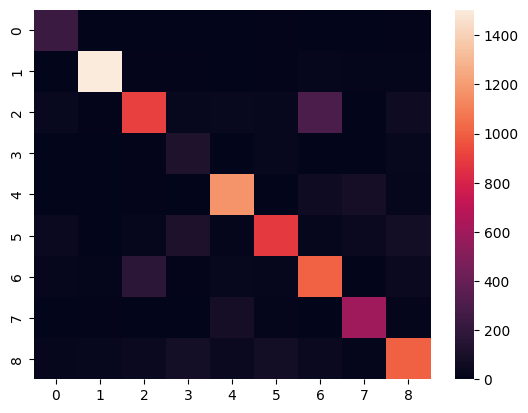

In [142]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print(cm)
sns.heatmap(cm)

縦軸が真の結果、横軸が判定結果である．２を６と判定してしまうもの、６を２と判定してしまうものが多いという結果が得られた．

In [133]:
auc_m1 = roc_auc_score(y_test, y_pred, multi_class="ovr")
print('AUC:',auc_m1)

AUC: 0.9717127448695376


In [ ]:
M1_y_score = np.array(M1_y_score)
M2_y_score = np.array(M2_y_score)
M3_y_score = np.array(M3_y_score)